# Step 1: Import the packages

In [1]:
import ccxt
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Data Collection using ccxt
This code fetches historical OHLCV (Open, High, Low, Close, Volume) data for the BTC/USDT trading pair from Binance using the `ccxt` library. 

1. **Function `fetch_ohlcv`:**
   - Initializes the Binance exchange.
   - Fetches OHLCV data in a loop until the current time is reached.
   - Handles up to 1000 data points per request due to API limits.
   - Collects and stores data in a list, then converts it to a Pandas DataFrame.

2. **Data Fetching:**
   - Retrieves BTC/USDT data from January 1, 2018, with a 6-hour timeframe.
   - Converts timestamps to datetime format and sets them as the DataFrame index.

3. **Feature Engineering:**
   - Calculates returns as the percentage change in the closing price.
   - Creates a binary label: assigns 1 if the return is greater than or equal to 0.05%, otherwise assigns 0.

This setup allows analysis of BTC/USDT price movements and simple classification based on return thresholds.

In [2]:
# Fetch historical OHLCV data
def fetch_ohlcv(symbol, timeframe, since, limit=1000):
    exchange = ccxt.binance()
    all_data = []
    while since < exchange.milliseconds():
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit=limit)
            all_data += ohlcv
            since = ohlcv[-1][0] + 1
            time.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"Error fetching data: {e}")
            break
    return pd.DataFrame(all_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

# Fetch BTC/USD data and compute features
symbol = 'BTC/USDT'
timeframe = '6h'
since = ccxt.binance().parse8601('2018-01-01T00:00:00Z')
stock_data = fetch_ohlcv(symbol, timeframe, since)

# Convert timestamp to datetime and set index
stock_data['timestamp'] = pd.to_datetime(stock_data['timestamp'], unit='ms')
stock_data.set_index('timestamp', inplace=True)

# Add returns as a simple target: 1 if return >= 0.25%, else 0
threshold = 0.0005  # 0.05% threshold for positive returns
stock_data['Returns'] = stock_data['close'].pct_change()
stock_data['Label'] = stock_data['Returns'].apply(lambda x: 1 if x >= threshold else 0)

Error fetching data: list index out of range


# Step 3: Feature Engineering

These codes computes technical indicators for financial data analysis:

1. **Open - Close:** Difference between open and close prices.
2. **High - Low:** Difference between high and low prices.
3. **SMA:** Simple Moving Average over specified periods.
4. **EMA:** Exponential Moving Average over specified periods.
5. **RSI:** Evaluates price changes for overbought/oversold conditions.
6. **MACD:** Difference between fast and slow EMAs with a signal line.
7. **Bollinger Bands:** Moving average with bands at 2 standard deviations.

### FeaturesComputation Class

- Computes features and returns them in a dictionary.
- Converts features to a DataFrame, aligns with the index, and drops missing values.

### Data Preparation

- `X`: Feature matrix.
- `y`: Target labels aligned with `X`.

Useful for predictive modeling and trend analysis.

In [3]:
# Feature 1: Open - Close
def openClose(open, close, lag=1):
    return (open.shift(lag) - close.shift(lag)).values

# Feature 2: High - Low
def highLow(high, low, lag=1):
    return (high.shift(lag) - low.shift(lag)).values

# Feature 3: Simple Moving Average (SMA)
def SMA(close, lag_list=[5, 15]):
    return [close.rolling(lag).mean().values for lag in lag_list]

# Feature 4: Exponential Moving Average (EMA)
def EMA(close, lag_list=[10, 20]):
    return [close.ewm(span=lag, adjust=False).mean().values for lag in lag_list]

# Feature 5: Relative Strength Index (RSI)
def RSI(close, window=14):
    delta = close.diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs)).values

# Feature 6: Moving Average Convergence Divergence (MACD)
def MACD(close, fast=12, slow=26, signal=9):
    fast_ema = close.ewm(span=fast, adjust=False).mean()
    slow_ema = close.ewm(span=slow, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd.values, signal_line.values

# Feature 7: Bollinger Bands
def BollingerBands(close, window=20, num_sd=2):
    rolling_mean = close.rolling(window=window).mean()
    rolling_std = close.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_sd)
    lower_band = rolling_mean - (rolling_std * num_sd)
    return upper_band.values, lower_band.values

class FeaturesComputation:
    def __init__(self, dataset):
        self.dataset = dataset

    def compute_features(self):
        sma_features = dict(zip(["SMA_" + str(lag) for lag in [5, 15]], SMA(self.dataset['close'])))
        ema_features = dict(zip(["EMA_" + str(lag) for lag in [10, 20]], EMA(self.dataset['close'])))
        macd, signal_line = MACD(self.dataset['close'])
        upper_band, lower_band = BollingerBands(self.dataset['close'])

        return {
            "openClose": openClose(self.dataset['open'], self.dataset['close']),
            "highLow": highLow(self.dataset['high'], self.dataset['low']),
            "RSI": RSI(self.dataset['close']),
            "MACD": macd,
            "Signal_Line": signal_line,
            "Upper_Band": upper_band,
            "Lower_Band": lower_band,
            **sma_features,
            **ema_features
        }

# Compute features
features_df = pd.DataFrame(FeaturesComputation(stock_data).compute_features())
features_df.index = stock_data.index
features_df.dropna(inplace=True)

# Prepare the data
X = features_df
y = stock_data['Label'].loc[X.index]

# Step 4: Data Process
The `DataProcess` class preprocesses data by scaling features and splitting them into training and testing sets.

### Key Features:

- **Scaling:**
  - Uses `StandardScaler` to standardize features.

- **Splitting:**
  - Splits data into training and testing sets with `train_test_split`.
  - Maintains sequence order (important for time series).

### Usage:

- Instantiate with feature matrix `X` and target `y`.
- Access `X_train`, `X_test`, `y_train`, `y_test` for model use.

In [4]:
class DataProcess:
    def __init__(self, X, y, testsize=0.3):
        self.X = X
        self.y = y
        self.testsize = testsize
        self.X_scaled = self.scale_data()
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()

    def scale_data(self):
        scaler = StandardScaler()
        return scaler.fit_transform(self.X)

    def split_data(self):
        return train_test_split(self.X_scaled, self.y, test_size=self.testsize, random_state=42, shuffle=False)

# Preprocess and train-test split
data_process = DataProcess(X, y, testsize=0.2)
X_train, X_test, y_train, y_test = data_process.X_train, data_process.X_test, data_process.y_train, data_process.y_test


# Step 5: Model Building and Hyperparameter Tuning (SVM)
The `SVM_Classifier` function builds and evaluates an SVM classifier with the following steps:

1. **Model Setup**:
   - Uses `svm.SVC` with probability estimates.
   - Defines a parameter grid for hyperparameters: `C`, `gamma`, and `kernel`.
   - Uses `TimeSeriesSplit` for cross-validation.

2. **Grid Search**:
   - Performs grid search with cross-validation to find the best parameters based on accuracy.

3. **Training and Predictions**:
   - Trains the model using the best parameters.
   - Makes predictions and calculates probabilities on the test set.

4. **Evaluation Metrics**:
   - Prints best parameters and accuracy for both training and test sets.
   - Displays a classification report and a confusion matrix using a heatmap.

5. **ROC Curve and AUC**:
   - Computes and plots the ROC curve and calculates the AUC to evaluate model performance.

The function provides a comprehensive evaluation of the model's performance using both accuracy and ROC metrics.

In [5]:
# SVM Classifier with Grid Search and Evaluation Metrics
def SVM_Classifier(X_train, y_train, X_test, y_test):
    classifier = svm.SVC(probability=True)
    param_grid = {'C': [300], 'gamma': ['scale'], 'kernel': ['linear']}
    tscv = TimeSeriesSplit(n_splits=5, gap=1)
    grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=tscv, n_jobs=-1)

    # Train the model
    grid_search.fit(X_train, y_train)

    # Results
    print("Best Parameters:", grid_search.best_params_)
    
    # Predictions
    y_pred = grid_search.predict(X_test)
    y_pred_prob = grid_search.predict_proba(X_test)[:, 1]

    # Accuracy
    print("Training Accuracy:", accuracy_score(y_train, grid_search.predict(X_train)))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', cbar=False)
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC curve (AUC): {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Step 6: Model Evaluation
Finally, we will evaluate the model using the ROC AUC, confusion matrix, and classification report.

Best Parameters: {'C': 300, 'gamma': 'scale', 'kernel': 'linear'}
Training Accuracy: 0.6484680368175514
Test Accuracy: 0.6732223903177005

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70      1012
           1       0.69      0.60      0.64       971

    accuracy                           0.67      1983
   macro avg       0.68      0.67      0.67      1983
weighted avg       0.68      0.67      0.67      1983



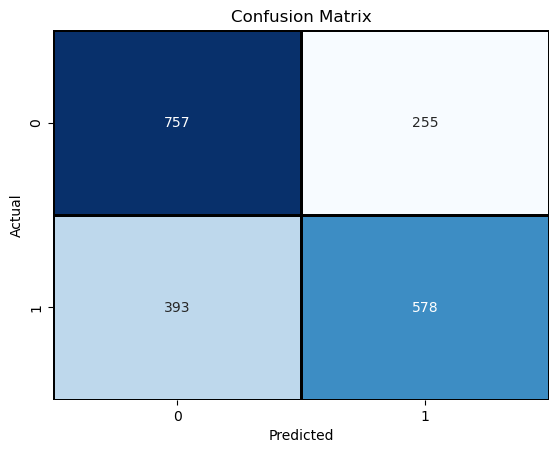

Area under ROC curve (AUC): 0.7280


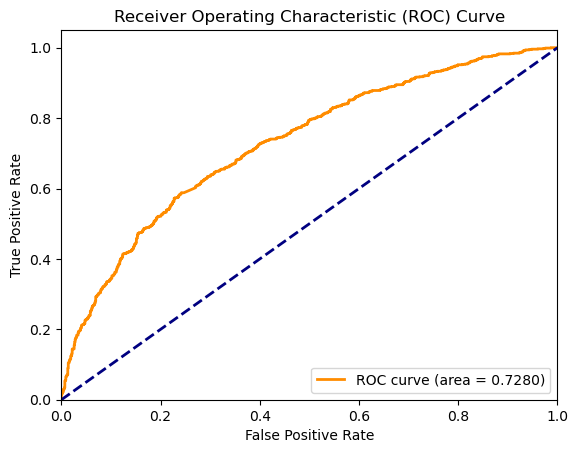

In [6]:
# Train and evaluate the model
SVM_Classifier(X_train, y_train, X_test, y_test)